In [1]:
#| default_exp app_v1

#### Competition

[LINK](https://www.kaggle.com/competitions/playground-series-s3e11/overview)

#### Imports

In [2]:
#| export
from fastai.tabular.all import *

#### Downloading Datasets

In [3]:
#| export
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [4]:
#| export
comp = 'playground-series-s3e11'
path = setup_comp(comp, install='fastai')

In [5]:
# copy .gitignore template from my home directory and append project data folder to it
if not os.path.exists('.gitignore'):
    !cp ~/.gitignore .
if comp not in open('.gitignore').read():
    with open('.gitignore', 'a') as f: f.write(f'{comp}')

#### Create Dataframes

In [6]:
#| export
df_train = pd.read_csv(path/'train.csv', low_memory=False)
df_test = pd.read_csv(path/'test.csv', low_memory=False)

In [8]:
list(df_train.columns)

['id',
 'store_sales(in millions)',
 'unit_sales(in millions)',
 'total_children',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'gross_weight',
 'recyclable_package',
 'low_fat',
 'units_per_case',
 'store_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist',
 'cost']

In [8]:
#| export
df_comb = pd.concat([df_train, df_test], ignore_index=True)

In [9]:
len(df_train) + len(df_test) == len(df_comb)

True

In [10]:
#| export
train_idxs = np.arange(len(df_train))

In [11]:
#| export
test_idxs = np.arange(len(df_train), len(df_comb))

In [12]:
#| export
dep_var = 'cost'

In [13]:
#| export
procs = [Categorify, FillMissing, Normalize]

In [14]:
#| export
cont, cat = cont_cat_split(df_comb, max_card=1, dep_var=dep_var)

In [18]:
#| export
splits = RandomSplitter(valid_pct=0.2)(range_of(df_train))

In [15]:
#| export
df_train = df_comb.iloc[train_idxs]
df_test = df_comb.iloc[test_idxs]

In [16]:
len(df_train) + len(df_test) == len(df_comb)

True

In [19]:
#| export
to = TabularPandas(df_train, procs, cat, cont, y_names=dep_var, splits=splits)

In [20]:
to.train.xs.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
7100,-1.664502,0.424008,-1.330779,1.708532,-0.567639,-0.187767,1.706371,0.872274,-0.698752,-0.389928,-1.168067,0.877464,-0.620148,-1.010584,-1.010640,-1.006658
10505,-1.631776,-1.180566,-0.056532,-0.306484,-0.567639,-0.187767,-0.351752,-1.146428,-0.698752,-0.194073,-0.082972,0.877464,1.612517,0.989526,0.989471,0.993386
342672,1.560756,0.043262,-0.056532,-0.306484,-0.567639,-0.187767,-1.136006,0.872274,-0.698752,0.099709,-0.850360,0.877464,1.612517,0.989526,0.989471,0.993386
93177,-0.837196,-1.576421,-1.330779,-1.649827,-0.567639,-0.187767,0.623148,-1.146428,-0.698752,1.372765,0.436715,0.877464,1.612517,0.989526,0.989471,0.993386
170469,-0.094326,-1.473680,-1.330779,-0.306484,1.080581,-0.187767,-0.200101,0.872274,-0.698752,-1.271275,1.393354,-1.139647,-0.620148,-1.010584,-1.010640,-1.006658


In [23]:
to.train.xs.shape

(288269, 16)

In [24]:
#| export
dls = to.dataloaders(bs=1024)

In [25]:
#| export
learn = tabular_learner(dls, layers=[200,100], metrics=rmse)

SuggestedLRs(valley=0.0691830962896347, slide=6.309573450380412e-07)

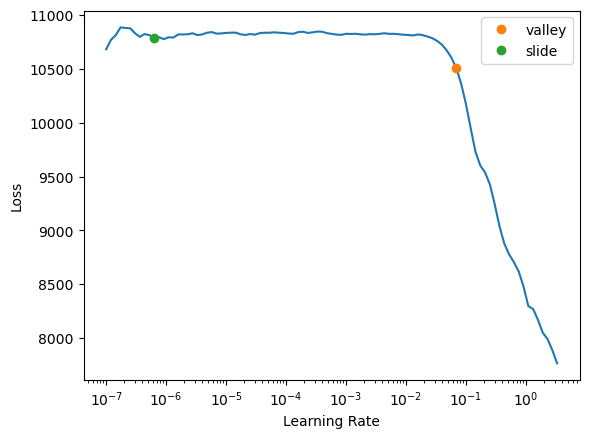

In [27]:
learn.lr_find(suggest_funcs=(valley,slide))

In [29]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,_rmse,time
0,826.924927,831.836060,28.841570,00:02
1,838.955627,837.937012,28.947142,00:02
2,829.555786,829.830566,28.806782,00:02
3,829.731934,828.470520,28.783165,00:02
4,821.106018,821.112061,28.655052,00:02
5,814.014099,816.454651,28.573668,00:02
6,811.565125,808.738464,28.438326,00:02
7,804.296692,805.908752,28.388529,00:02
8,801.619690,802.297668,28.324860,00:02
9,800.378357,801.399292,28.308994,00:02


In [30]:
#| export
xs, ys = to.train.xs, to.train.ys
valid_xs, valid_ys = to.valid.xs, to.valid.ys

In [31]:
#| export
test_dl = learn.dls.test_dl(df_test)

In [33]:
#| export
preds = learn.get_preds(dl=test_dl)

In [38]:
preds

(tensor([[100.7270],
         [ 98.3200],
         [ 99.2370],
         ...,
         [ 99.2532],
         [108.5288],
         [103.2632]]),
 tensor([[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]]))

In [35]:
len(df_test) == len(preds[0])

True

In [36]:
#| export
sample_df = pd.read_csv(path/'sample_submission.csv')

In [39]:
#| export
sample_df['cost'] = preds[0]

In [40]:
#| export
sample_df.to_csv('submission.csv', index=False)

In [42]:
!head submission.csv

id,cost
360336,100.727005
360337,98.31998
360338,99.23696
360339,100.563896
360340,82.47281
360341,102.12399
360342,110.87849
360343,92.2671
360344,92.96241


In [44]:
comp

'playground-series-s3e11'

In [51]:
submit = False

In [52]:
if not iskaggle and submit:
    from kaggle import api
    api.competition_submit_cli(file_name='submission.csv', message="baseline model", competition=comp)

In [1]:
import nbdev
nbdev.export.nb_export('media_campaign_cost.ipynb', 'app_v1')
print("export successful")

export successful
